**Problem statement:**
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/My Drive/Colab Notebooks/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/gdrive/My Drive/Colab Notebooks/CNN Assignment//Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset = "training",
    seed = 123,
    image_size = (img_height,img_width),
    batch_size = batch_size
)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    image_size = (img_height,img_width),
    batch_size = batch_size

)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [9]:
num_classes = len(val_ds.class_names)
num_classes

9

In [11]:
#class names
val_ds.class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

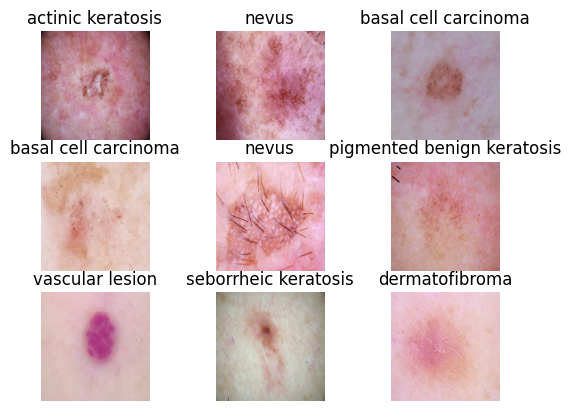

In [13]:
import matplotlib.pyplot as plt

for i in range(len(class_names)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[i]])
        plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [15]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.13676472 0.9081697


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [16]:
### Todo, choose an appropirate optimiser and loss function
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [19]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 71s 1s/step - loss: 2.2485 - accuracy: 0.2561 - val_loss: 1.8038 - val_accuracy: 0.4139
Epoch 2/20
56/56 [==============================] - 1s 21ms/step - loss: 1.8641 - accuracy: 0.3315 - val_loss: 1.7706 - val_accuracy: 0.4161
Epoch 3/20
56/56 [==============================] - 1s 21ms/step - loss: 1.6290 - accuracy: 0.4247 - val_loss: 1.5592 - val_accuracy: 0.4474
Epoch 4/20
56/56 [==============================] - 1s 21ms/step - loss: 1.5104 - accuracy: 0.4782 - val_loss: 1.5238 - val_accuracy: 0.4855
Epoch 5/20
56/56 [==============================] - 1s 23ms/step - loss: 1.3931 - accuracy: 0.5206 - val_loss: 1.4875 - val_accuracy: 0.5123
Epoch 6/20
56/56 [==============================] - 1s 24ms/step - loss: 1.2993 - accuracy: 0.5407 - val_loss: 1.4538 - val_accuracy: 0.5123
Epoch 7/20
56/56 [==============================] - 1s 21ms/step - loss: 1.2522 - accuracy: 0.5564 - val_loss: 1.3412 - val_accuracy: 0.5302
Epoch 8/20
56/

### Visualizing training results

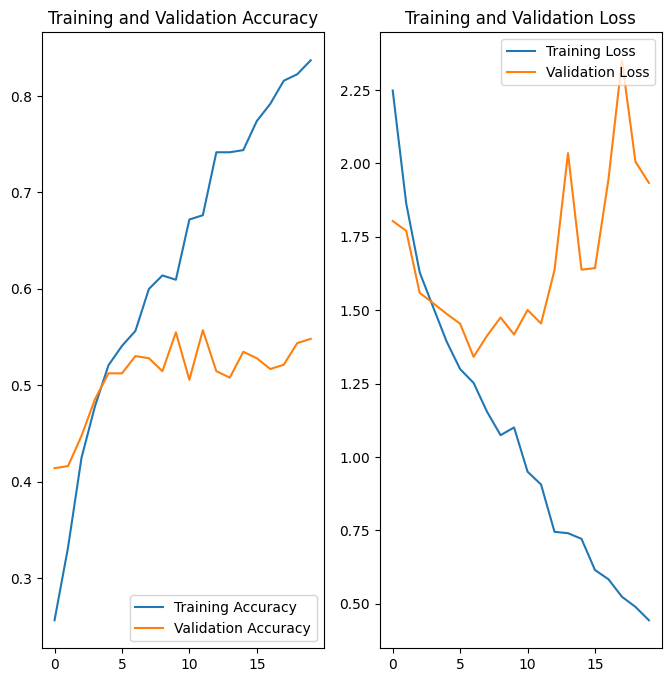

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observations**: The model appears to be overfitting since training accuracy is very high and the validation accuracy is low.

**Since these are images are of skin, there is a possibility that actual images might have been taken from different direction/angle hence horizontal and vertial flip is applied**

In [21]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

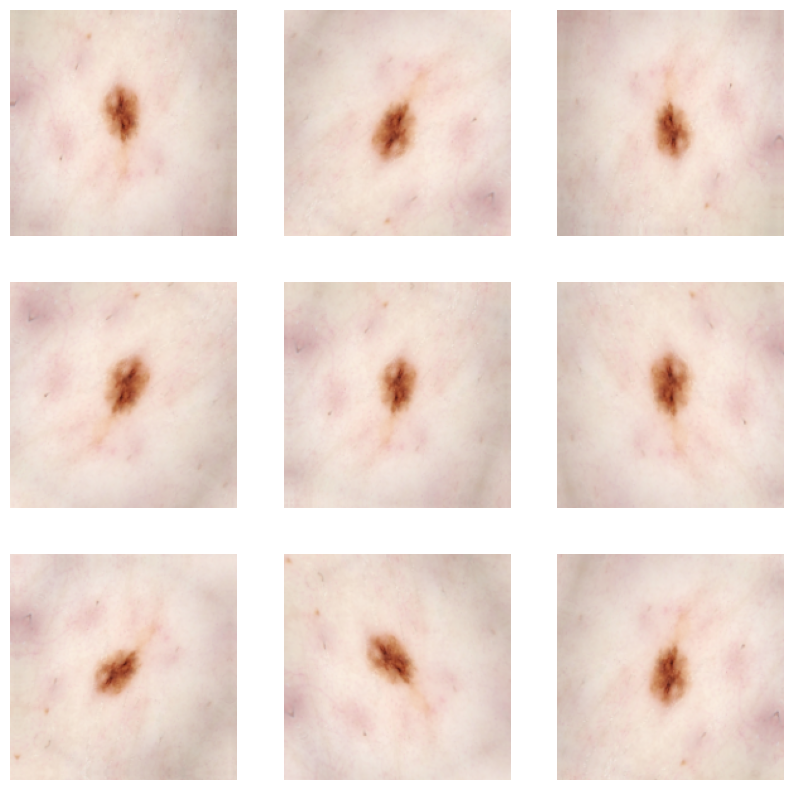

In [22]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [23]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])



### Compiling the model

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [25]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 33ms/step - loss: 1.9795 - accuracy: 0.2662 - val_loss: 1.7939 - val_accuracy: 0.3848
Epoch 2/20
56/56 [==============================] - 2s 29ms/step - loss: 1.7599 - accuracy: 0.3811 - val_loss: 1.6037 - val_accuracy: 0.4228
Epoch 3/20
56/56 [==============================] - 2s 29ms/step - loss: 1.5428 - accuracy: 0.4542 - val_loss: 1.4810 - val_accuracy: 0.4855
Epoch 4/20
56/56 [==============================] - 2s 30ms/step - loss: 1.4002 - accuracy: 0.5089 - val_loss: 1.4524 - val_accuracy: 0.4832
Epoch 5/20
56/56 [==============================] - 2s 32ms/step - loss: 1.3566 - accuracy: 0.5173 - val_loss: 1.3699 - val_accuracy: 0.5302
Epoch 6/20
56/56 [==============================] - 2s 30ms/step - loss: 1.3278 - accuracy: 0.5229 - val_loss: 1.3096 - val_accuracy: 0.5638
Epoch 7/20
56/56 [==============================] - 2s 29ms/step - loss: 1.2972 - accuracy: 0.5519 - val_loss: 1.4203 - val_accuracy: 0.4944
Epoch 8/20
56

### Visualizing the results

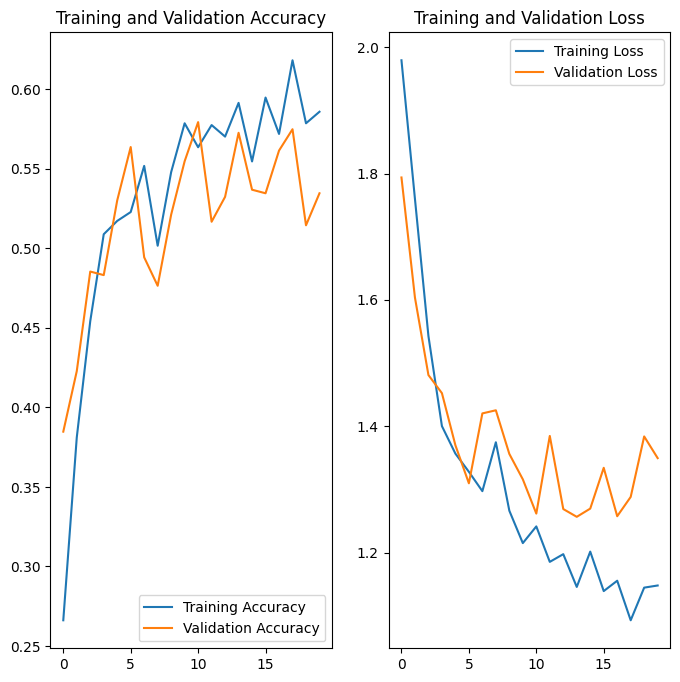

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observations** : There have been some improvement with regards to the overfitting of the model. However the overall accuracy is still bit low.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

**Checking Class Distribution**

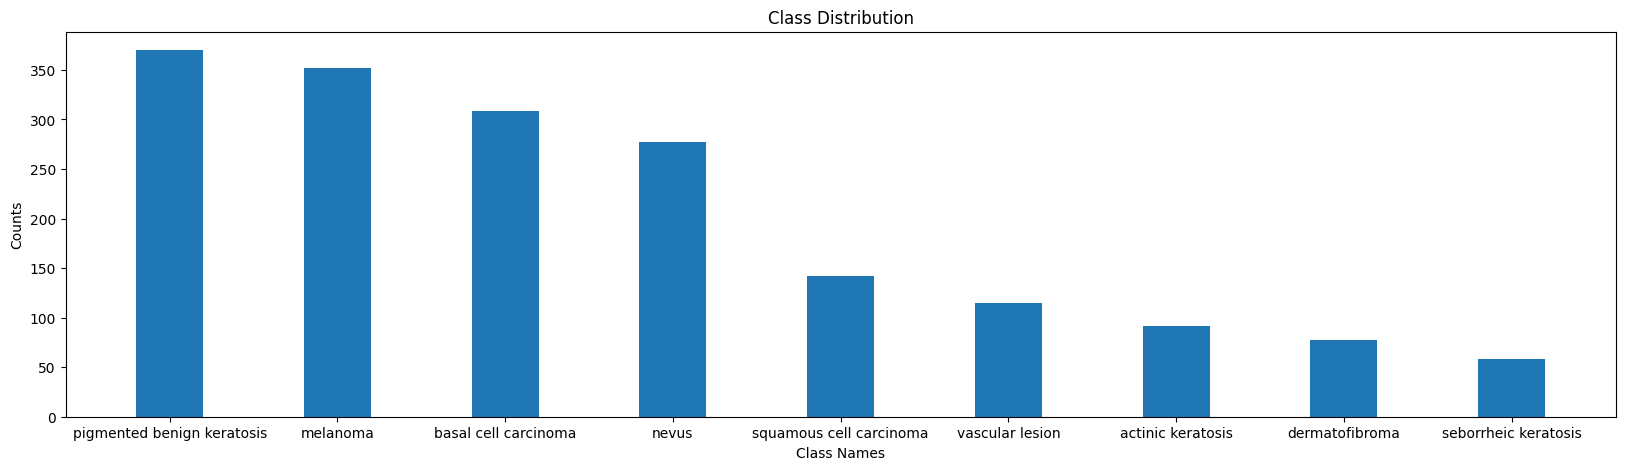

In [27]:
labels = []
for x, y in train_ds:
  labels.append(y.numpy())
labels = np.concatenate(labels, axis = 0)
train_df = pd.DataFrame(labels)
train_df.columns = ['Index']
train_df['Label'] = train_df['Index'].apply(lambda x: class_names[x])
freq = train_df['Label'].value_counts()

fig = plt.figure(figsize = (20, 5))

plt.bar(freq.index, freq.values, width = 0.4)

plt.xlabel("Class Names")
plt.ylabel("Counts")
plt.title("Class Distribution")
plt.show()

**Observations**:
- Which class has the least number of samples? - **pigmented benign keratosis**
- Which classes dominate the data in terms proportionate number of samples? - **seborrheic keratosis**

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [28]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [29]:
path_to_training_dataset= str(data_dir_train) + "/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DBFC0223760>: 100%|██████████| 500/500 [00:18<00:00, 27.15 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DBFC064AB90>: 100%|██████████| 500/500 [00:18<00:00, 26.41 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DBFC02EEB90>: 100%|██████████| 500/500 [00:18<00:00, 26.79 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7DBFDA3C71F0>: 100%|██████████| 500/500 [01:35<00:00,  5.23 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2565x2000 at 0x7DBFC04B3940>: 100%|██████████| 500/500 [01:09<00:00,  7.15 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7DBFC02C3D60>: 100%|██████████| 500/500 [00:20<00:00, 24.51 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7DBFC02EF0D0>: 100%|██████████| 500/500 [00:41<00:00, 12.11 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7DBFC026F9A0>: 100%|██████████| 500/500 [00:19<00:00, 26.22 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DBFC04EC9A0>: 100%|██████████| 500/500 [00:19<00:00, 26.00 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [30]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [33]:
path_list = [x for x in data_dir_train.glob('*/output/*.jpg')]
path_list

[PosixPath('/content/gdrive/My Drive/Colab Notebooks/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028190.jpg_823906fd-7416-4fd1-b1c5-4f9dc9d548a7.jpg'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027452.jpg_abe806e2-64a6-4600-9189-6757f4cc8ee0.jpg'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028076.jpg_5dbd4598-4652-4218-a735-0dd883588f3f.jpg'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030133.jpg_affe743d-629a-49d7-b260-33bdadeb99ab.jpg'),
 Pos

In [40]:
import os
from pathlib import Path

# Assuming 'data_dir_train' is a PosixPath object
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in data_dir_train.glob('*/output/*.jpg')]
# Use a relative pattern for glob
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [42]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [45]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [46]:
df2['Label'].value_counts()

Label
actinic keratosis             500
seborrheic keratosis          500
dermatofibroma                500
basal cell carcinoma          500
vascular lesion               500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
squamous cell carcinoma       500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [47]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [49]:
data_dir_train=pathlib.Path("/content/gdrive/My Drive/Colab Notebooks/CNN Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [50]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [51]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [52]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.035293583 0.83627456


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [53]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [54]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [55]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [56]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 16s 83ms/step - loss: 1.8933 - accuracy: 0.2791 - val_loss: 1.6196 - val_accuracy: 0.3905
Epoch 2/30
169/169 [==============================] - 6s 33ms/step - loss: 1.5229 - accuracy: 0.4227 - val_loss: 1.4117 - val_accuracy: 0.4558
Epoch 3/30
169/169 [==============================] - 5s 31ms/step - loss: 1.4294 - accuracy: 0.4507 - val_loss: 1.4369 - val_accuracy: 0.4491
Epoch 4/30
169/169 [==============================] - 5s 32ms/step - loss: 1.3695 - accuracy: 0.4690 - val_loss: 1.2342 - val_accuracy: 0.5063
Epoch 5/30
169/169 [==============================] - 5s 30ms/step - loss: 1.3208 - accuracy: 0.4939 - val_loss: 1.2849 - val_accuracy: 0.4996
Epoch 6/30
169/169 [==============================] - 5s 31ms/step - loss: 1.2553 - accuracy: 0.5111 - val_loss: 1.2119 - val_accuracy: 0.5063
Epoch 7/30
169/169 [==============================] - 5s 31ms/step - loss: 1.2308 - accuracy: 0.5172 - val_loss: 1.4175 - val_accuracy: 0.453

#### **Todo:**  Visualize the model results

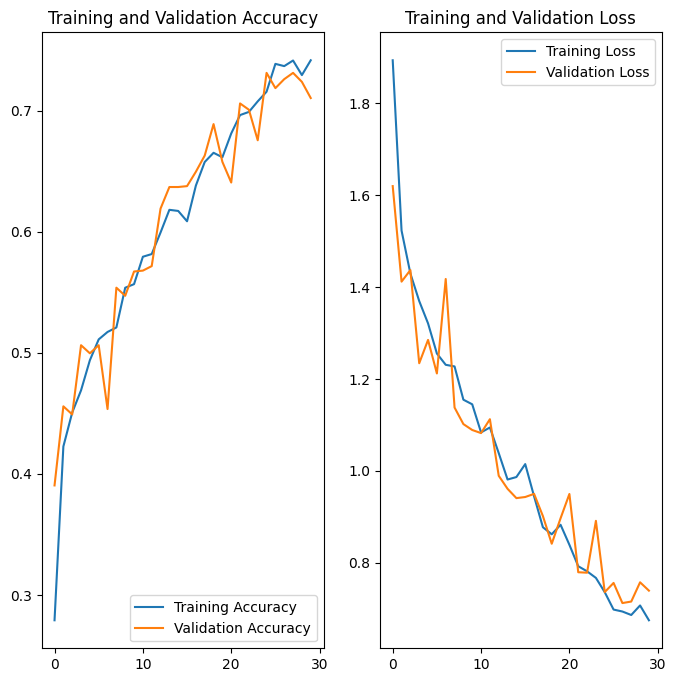

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observations** : There has been significant improvement in the overall model performace after the augmentation. Overall accuracy is improved.


*   Number of images in training data affects accuracy
*   Augmentation helps to make sure model trains correctly on variations


Increase in epochs may also increases the chances of accuracy. Lets try with epochs = 50

In [58]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 5s 31ms/step - loss: 0.6527 - accuracy: 0.7543 - val_loss: 0.6586 - val_accuracy: 0.7602
Epoch 2/50
169/169 [==============================] - 5s 30ms/step - loss: 0.6411 - accuracy: 0.7639 - val_loss: 0.7064 - val_accuracy: 0.7446
Epoch 3/50
169/169 [==============================] - 5s 31ms/step - loss: 0.6288 - accuracy: 0.7654 - val_loss: 0.6740 - val_accuracy: 0.7558
Epoch 4/50
169/169 [==============================] - 5s 30ms/step - loss: 0.6033 - accuracy: 0.7741 - val_loss: 0.7321 - val_accuracy: 0.7357
Epoch 5/50
169/169 [==============================] - 5s 29ms/step - loss: 0.5526 - accuracy: 0.7875 - val_loss: 0.6346 - val_accuracy: 0.7610
Epoch 6/50
169/169 [==============================] - 5s 31ms/step - loss: 0.5367 - accuracy: 0.7967 - val_loss: 0.6978 - val_accuracy: 0.7558
Epoch 7/50
169/169 [==============================] - 5s 30ms/step - loss: 0.5643 - accuracy: 0.7884 - val_loss: 0.6638 - val_accuracy: 0.7699

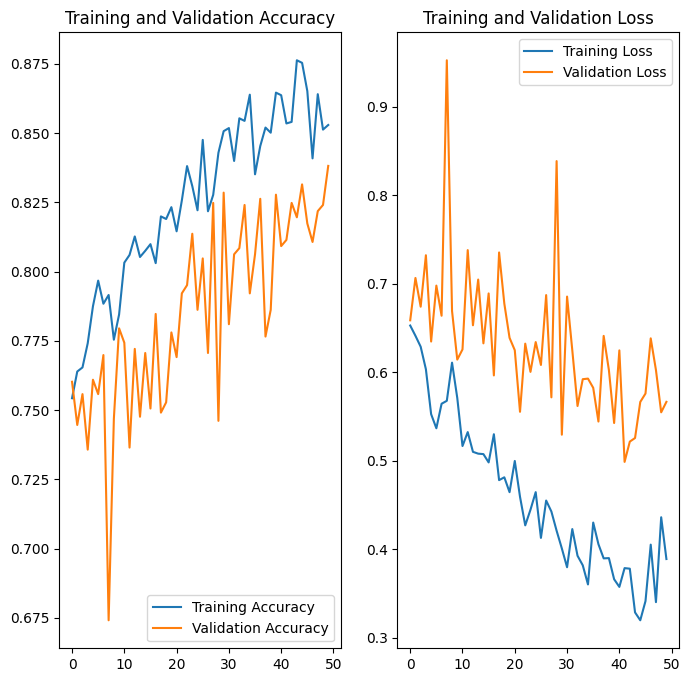

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [68]:
print ("Max. Training Accuracy =", max(acc)*100)

Max. Training Accuracy = 87.62982487678528


In [69]:
print ("Max. Validation Accuracy =", max(val_acc)*100)

Max. Validation  Accuracy = 83.81588459014893


With epoch 50 we have good train accuracy = **88%**
And Validation Accuracy = **84%**